# SDOT Trees Data Exploration

## TODO

* Figure out how  to superimpose the tree locations on top of a map of Seattle accurately.
* Create a new column to classify trees by their scientific name, but group very specific cultivars together.
  - Identify any filterable data (e.g. there are trees with name "stump").

# Notes

* The `x` and `y` columns are likely measured in feet based on the State Plane Coordinate System (SPCS) for Washington North (EPSG:2285).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, TypedDict

In [34]:
df_raw = pd.read_csv('data/sdot_trees/SDOT_Trees_CDL_20241119.csv', dtype={
    'CONDITION': 'string',
    'CONDITION_ASSESSMENT_DATE': 'string',
    'ASBUILTPLANNO': 'string',
})

# to squelch warnings about the data
df_raw['CONDITION'] = df_raw['CONDITION'].fillna('')
df_raw['CONDITION_ASSESSMENT_DATE'] = df_raw['CONDITION_ASSESSMENT_DATE'].fillna('')
df_raw['ASBUILTPLANNO'] = df_raw['ASBUILTPLANNO'].fillna('')

# to sanitize the data
df_raw['SCIENTIFIC_NAME'] = df_raw['SCIENTIFIC_NAME'].fillna('')
df_raw['COMMON_NAME'] = df_raw['COMMON_NAME'].fillna('')

In [22]:
print(df_raw.columns)

Index(['OBJECTID', 'COMPKEY', 'UNITID', 'UNITDESC', 'CONDITION',
       'CONDITION_ASSESSMENT_DATE', 'CURRENT_STATUS', 'PRIMARYDISTRICTCD',
       'SECONDARYDISTRICTCD', 'OVERRIDEYN', 'COMPTYPE', 'SEGKEY', 'UNITTYPE',
       'OWNERSHIP', 'CURRENT_STATUS_DATE', 'LAST_VERIFY_DATE', 'PLANTED_DATE',
       'BOTANICAL_NAME', 'SCIENTIFIC_NAME', 'HERITAGE', 'EXCEPTIONAL',
       'CODEREQ', 'GSI', 'GREEN_FACTOR', 'WIRES', 'CABLED',
       'CLEARANCE_PROBLEM', 'SPACETYPE', 'SITETYPE', 'GROWSPACE', 'DIAM',
       'CONDITION_RATING', 'FUNDING_SOURCE', 'WATER_THROUGH_YR1',
       'WATER_THROUGH_YR2', 'WATER_THROUGH_YR3', 'OWNERDIAM', 'EXPDATE',
       'COMMON_NAME', 'TREEHEIGHT', 'ASBUILTPLANNO', 'LANDSCAPEAREAASSOC',
       'COMMENTS', 'OVERRIDECOMMENT', 'SHAPE_LNG', 'SHAPE_LAT',
       'IRRIGATESYSYN', 'ASSETGROUPID', 'ASSETGROUPDESC', 'MODDATE',
       'TOTAL_RANK', 'TOTAL_COUNT', 'GENUS', 'UFMAINTMGMTUNIT', 'x', 'y'],
      dtype='object')


In [25]:
print(df_raw[:4])

   OBJECTID  COMPKEY       UNITID             UNITDESC CONDITION  \
0  72121582   218151    TRE-50439          2033 1ST AV             
1  72121583   218188    TRE-50476         1810 6TH AVE             
2  72121584   229512    TRE-61800        555 N 73RD ST             
3  72121585   349628  TRE-1032635  10745 PALATINE AV N             

  CONDITION_ASSESSMENT_DATE CURRENT_STATUS PRIMARYDISTRICTCD  \
0                                    INSVC         DISTRICT7   
1                                    INSVC         DISTRICT7   
2                                  REMOVED         DISTRICT6   
3                                  REMOVED         DISTRICT5   

  SECONDARYDISTRICTCD OVERRIDEYN  ...  IRRIGATESYSYN  ASSETGROUPID  \
0                 NaN          N  ...              N                 
1                 NaN          N  ...              N                 
2                 NaN          N  ...              N                 
3                 NaN          N  ...              N      

In [15]:
LOOKUP_MISSES = {}

def _clear_lookup_misses():
    global LOOKUP_MISSES
    LOOKUP_MISSES = {}

def _lookup_miss(kind: str, key: any):
    global LOOKUP_MISSES
    if kind in LOOKUP_MISSES:
        entries = LOOKUP_MISSES[kind]
    else:
        entries = LOOKUP_MISSES[kind] = set()
    if key not in entries:
        if len(entries) < 10:
            print(f'warning: lookup miss {kind=} {key=}')
        elif len(entries) == 10:
            print(f'warning: lookup miss {kind=} ...')
        entries.add(key)

def lookup_fertilization_direction(scientific_name_a: str, scientific_name_b: str) -> Tuple[bool, bool]:
    """returns a_to_b, b_to_a where a_to_b means a can fertilize b and b_to_a means b can fertilize a."""
    # assumed - a species can fertilize itself (TODO - probably not strictly true)
    if scientific_name_a == scientific_name_b:
        return True, True
    # TODO - get researching!
    _lookup_miss('fertilization_direction', (scientific_name_a, scientific_name_b))
    return False, False

def lookup_indigenous(row) -> bool:
    # TODO - handle the lat and lon values, but we're assuming a single biome for now in Seattle, WA
    scientific_name = row['SCIENTIFIC_NAME']
    if scientific_name == 'Cercidiphyllum japonicum':
        return False # https://gobotany.nativeplanttrust.org/species/cercidiphyllum/japonicum/
    # TODO - get researching!
    _lookup_miss('indigenous', (scientific_name, ))
    return True

class PollinationProfile(TypedDict):
    POLLINATION_TYPE: str # TODO one of INSECT, WIND, UNSPECIFIED
    POLLINATION_RANGE: float # meters - TODO validate what's x, y mean in the data?

# TODO for simplicity, one profile for insect and wind pollination is provided
INSECT_POLLINATOR_PROFILE: PollinationProfile = {
    'POLLINATION_TYPE': 'INSECT',
    'POLLINATION_RANGE': 200.0, # TODO reference
}
WIND_POLLINATOR_PROFILE: PollinationProfile = {
    'POLLINATION_TYPE': 'WIND',
    'POLLINATION_RANGE': 500.0, # TODO reference
}
UNSPECIFICED_POLLINATOR_PROFILE: PollinationProfile = {
    'POLLINATION_TYPE': 'UNSPECIFIED',
    'POLLINATION_RANGE': float('NaN'),
}

def lookup_pollination_profile(row) -> PollinationProfile:
    scientific_name = row['SCIENTIFIC_NAME']
    if scientific_name.lower().startswith('malus'): # TODO reference
        return INSECT_POLLINATOR_PROFILE
    # TODO - get researching!
    _lookup_miss('pollination_profile', (row['SCIENTIFIC_NAME'], ))
    return UNSPECIFICED_POLLINATOR_PROFILE

In [16]:
def insert_additional_information(df):
    def lookup_additional_information(row):
        result = {
            'INDIGENOUS': lookup_indigenous(row),
        }
        result.update(lookup_pollination_profile(row))
        return result

    _clear_lookup_misses()
    return df.join(df.apply(lookup_additional_information, axis=1).apply(pd.Series))

df = insert_additional_information(df_raw)

## Some Specific Trees

In [18]:
print(df[df['SCIENTIFIC_NAME'].str.startswith('Pseudotsuga')]['SCIENTIFIC_NAME'].value_counts())
print()
print(df[df['COMMON_NAME'].str.startswith('Bristle')]['SCIENTIFIC_NAME'].value_counts())
print()
#print(df[df['SCIENTIFIC_NAME'].str.startswith('Prunus')]['SCIENTIFIC_NAME'].value_counts())
#print()

#df[df['COMMON_NAME'].str.startswith('Bristle')]

SCIENTIFIC_NAME
Pseudotsuga menziesii    2435
Name: count, dtype: int64

SCIENTIFIC_NAME
Pinus aristata    27
Name: count, dtype: int64



## Where Are These Trees?

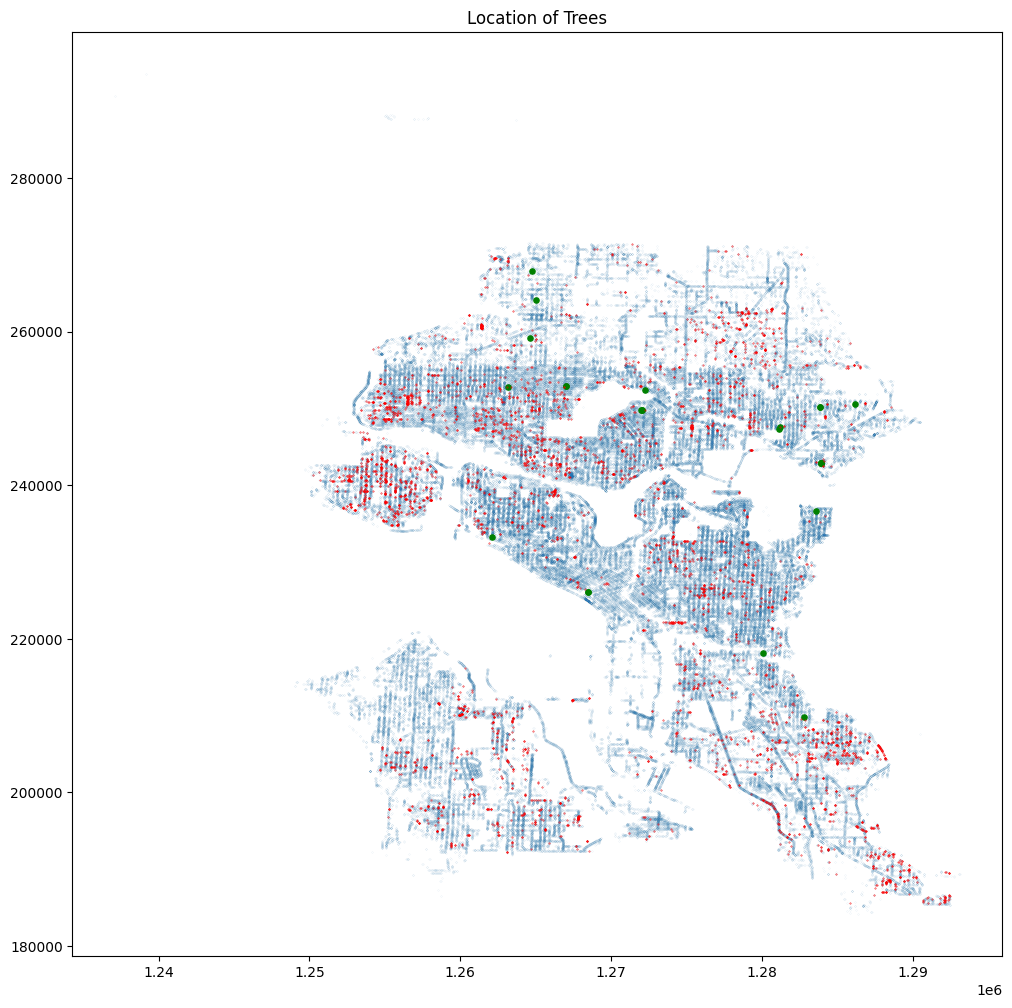

In [36]:
apples = df[df['SCIENTIFIC_NAME'].str.startswith('Malus')]
dfirs = df[df['SCIENTIFIC_NAME'].str.startswith('Pseudotsuga')]
bristles = df[df['SCIENTIFIC_NAME'] == 'Pinus aristata']
prunus = df[df['SCIENTIFIC_NAME'] == 'Prunus sp.']
plt.figure(figsize=(12, 12))
plt.scatter(df['x'], df['y'], s=.001)
#plt.scatter(apples['x'], apples['y'], s=.1, color='red')
plt.scatter(bristles['x'], bristles['y'], s=14, color='green')
#plt.scatter(dfirs['x'], dfirs['y'], s=.1, color='green')
plt.scatter(prunus['x'], prunus['y'], s=.1, color='red')
plt.title('Location of Trees')
plt.show()

In [8]:
LOOKUP_MISSES

{'pollination_profile': {('',),
  ('+ Laburnocytidus adamii',),
  ('Abies amabilis',),
  ('Abies concolor',),
  ('Abies grandis',),
  ('Abies koreana',),
  ('Abies pinsapo',),
  ('Abies procera',),
  ('Abies sp.',),
  ('Abies veitchii',),
  ('Acacia pravissima',),
  ('Acer buergerianum',),
  ('Acer campestre',),
  ("Acer campestre 'Panacek'",),
  ("Acer campestre 'Queen Elizabet",),
  ('Acer capillipes',),
  ('Acer cappadocicum',),
  ('Acer circinatum',),
  ('Acer davidii',),
  ('Acer glabrum',),
  ('Acer griseum',),
  ('Acer japonicum',),
  ('Acer macrophyllum',),
  ('Acer maximowiczianum',),
  ("Acer miyabei 'JFS-KW3AMI'",),
  ("Acer miyabei 'Morton'",),
  ('Acer monspessulanum',),
  ('Acer negundo',),
  ('Acer palmatum',),
  ("Acer palmatum 'Bihou'",),
  ("Acer palmatum 'Osakazuki'",),
  ("Acer palmatum 'Tobiosho'",),
  ('Acer palmatum `Sango Kaku`',),
  ('Acer palmatum var. dissectum',),
  ('Acer palmatum var. dissectum f',),
  ('Acer pensylvanicum',),
  ('Acer platanoides',),
  ("

In [28]:
df[df['SCIENTIFIC_NAME'] == 'Malus sp.']['COMMON_NAME'].value_counts()

COMMON_NAME
Apple/Crabapple    7016
Name: count, dtype: int64

In [33]:
df[df['SCIENTIFIC_NAME'].str.startswith('Prunus')]['SCIENTIFIC_NAME'].value_counts()

SCIENTIFIC_NAME
Prunus cerasifera cv/hyb          6176
Prunus serrulata                  5280
Prunus cerasifera `Thunderclou    4987
Prunus sp.                        4639
Prunus  `Kwanzan` (Sato Zakura    4320
Prunus x blireiana                4229
Prunus avium                      1642
Prunus x subhirtella              1047
Prunus x domestica                1008
Prunus x subhirtella `Autumnal     997
Prunus x yedoensis `Akebono`       910
Prunus x yedoensis                 793
Prunus  `Shirotae` (Sato Zakur     732
Prunus laurocerasus                717
Prunus pendula                     625
Prunus  `Amanogawa` (Sato Zaku     533
Prunus sargentii                   305
Prunus cerasus                     292
Prunus cerasifera `Krauter`s V     286
Prunus persica                     276
Prunus  `Accolade`                 225
Prunus  `Okame`                    214
Prunus serrula                     207
Prunus  `Newport`                  190
Prunus serotina                    158
Prunus  `